Modeling: Light Parametric + Mass Light Dark + Source Parametric
================================================================

In this script, we fit `Imaging` with a strong lens model where:

 - The lens galaxy's light is a parametric `EllSersic`.
 - The lens galaxy's stellar mass distribution is tied to the light model above.
 - The lens galaxy's dark matter mass distribution is a `EllNFW`.
 - The source galaxy's light is a parametric `EllSersic`.

In [1]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

from os import path
import autofit as af
import autolens as al
import autolens.plot as aplt

/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace`


__Dataset__

Load and plot the strong lens dataset `light_sersic__mass_mlr_nfw__source_sersic` via .fits files, which we will fit with 
the lens model.

In [2]:
dataset_name = "light_sersic__mass_mlr_nfw__source_sersic"
dataset_path = path.join("dataset", "imaging", "with_lens_light", dataset_name)

imaging = al.Imaging.from_fits(
    image_path=path.join(dataset_path, "image.fits"),
    psf_path=path.join(dataset_path, "psf.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    pixel_scales=0.1,
)

__Masking__

The model-fit requires a `Mask2D` defining the regions of the image we fit the lens model to the data, which we define
and use to set up the `Imaging` object that the lens model fits.

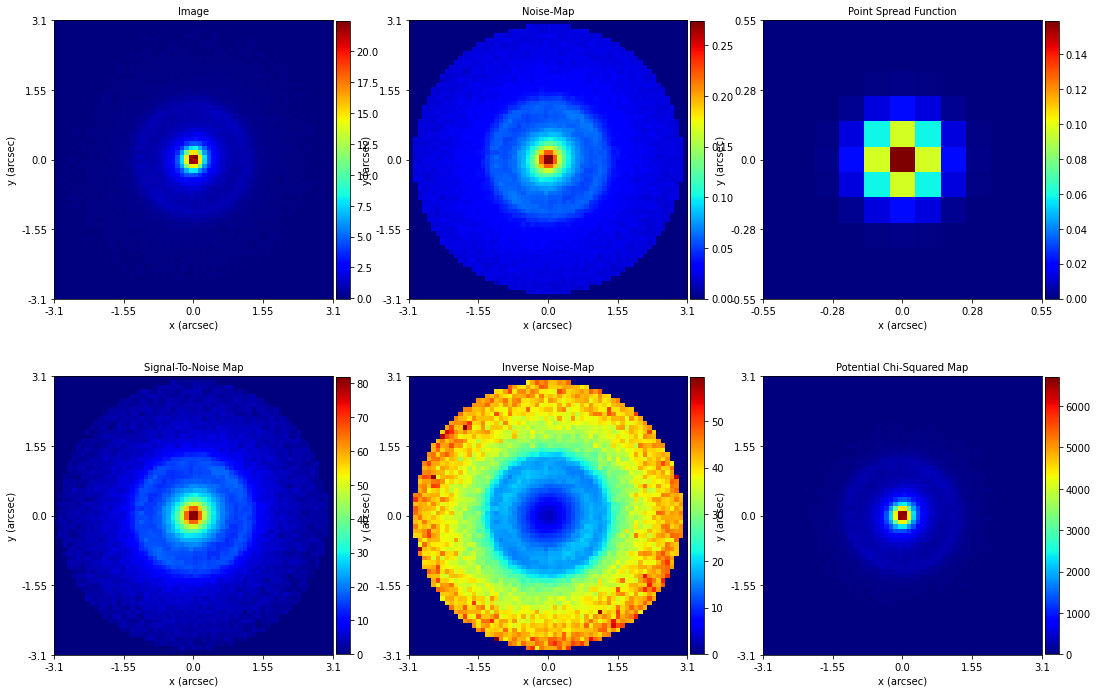

In [3]:
mask = al.Mask2D.circular(
    shape_native=imaging.shape_native, pixel_scales=imaging.pixel_scales, radius=3.0
)

imaging = imaging.apply_mask(mask=mask)

imaging_plotter = aplt.ImagingPlotter(imaging=imaging)
imaging_plotter.subplot_imaging()

__Model__

We compose our lens model using `Model` objects, which represent the galaxies we fit to our data. In this 
example we fit a lens model where:

 - The lens galaxy's light and stellar mass is a parametric `EllSersic` [8 parameters].
 
 - The lens galaxy's dark matter mass distribution is a `EllNFW` whose centre is aligned with the 
 `EllSersic` bulge of the light and stellar mass mdoel above [5 parameters].
 
 - The lens mass model also includes an `ExternalShear` [2 parameters].
 
 - The source galaxy's light is a parametric `EllSersic` [7 parameters].

The number of free parameters and therefore the dimensionality of non-linear parameter space is N=22.

NOTE: 

**PyAutoLens** assumes that the lens galaxy centre is near the coordinates (0.0", 0.0"). 

If for your dataset the  lens is not centred at (0.0", 0.0"), we recommend that you either: 

 - Reduce your data so that the centre is (`autolens_workspace/notebooks/preprocess`). 
 - Manually override the lens model priors (`autolens_workspace/notebooks/imaging/modeling/customize/priors.py`).

In [4]:
bulge = af.Model(al.lmp.EllSersic)
dark = af.Model(al.mp.EllNFW)
bulge.centre = dark.centre

lens = af.Model(
    al.Galaxy, redshift=0.5, bulge=bulge, dark=dark, shear=al.mp.ExternalShear
)
source = af.Model(al.Galaxy, redshift=1.0, bulge=al.lp.EllSersic)

model = af.Collection(galaxies=af.Collection(lens=lens, source=source))

__Search__

The lens model is fitted to the data using a non-linear search. In this example, we use the nested sampling algorithm 
Dynesty (https://dynesty.readthedocs.io/en/latest/). We make the following changes to the Dynesty __Settings__:

 - Increase the number of live points, `n_live_points`, from the default value of 50 to 100. 
 - Increase the number of random walks per live point, `walks` from the default value of 5 to 10. 
 
These changes are motivated by the higher dimensionality non-linear parameter space that including the lens light 
creates, which requires more thorough sampling by the non-linear search.

The folder `autolens_workspace/notebooks/imaging/modeling/customize/non_linear_searches` gives an overview of the 
non-linear searches **PyAutoLens** supports. If you are unclear of what a non-linear search is, checkout chapter 2 of 
the **HowToLens** lectures.

The `name` and `path_prefix` below specify the path where results ae stored in the output folder:  

 `/autolens_workspace/output/imaging/modeling/mass_sie__source_sersic/mass[sie]_source[bulge]`.

In [5]:
search = af.DynestyStatic(
    path_prefix=path.join("imaging", "modeling", dataset_name),
    name="light[bulge]_mass[mlr_nfw]_source[bulge]",
    n_live_points=100,
    walks=10,
)

__Analysis__

The `AnalysisImaging` object defines the `log_likelihood_function` used by the non-linear search to fit the model to 
the `Imaging`dataset.

In [6]:
analysis = al.AnalysisImaging(dataset=imaging)

__Model-Fit__

We can now begin the model-fit by passing the model and analysis object to the search, which performs a non-linear
search to find which models fit the data with the highest likelihood.

Checkout the folder `autolens_workspace/output/examples/mass[sie]_source[bulge]` for live outputs of the results of the
fit, including on-the-fly visualization of the best fit model!

In [7]:
result = search.fit(model=model, analysis=analysis)

/home/jammy/venvs/PyAuto/lib/python3.8/site-packages/dynesty/dynesty.py:373: UserWarning: A note of caution: having `nlive < ndim * (ndim + 1) // 2` may result in unconstrained bounding distributions.
  warnings.warn("A note of caution: "
INFO:root:No Dynesty samples found, beginning new non-linear search. 
2it [00:00,  6.84it/s, +100 | bound: 0 | nc: 1 | ncall: 102 | eff(%): 100.000 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-    nan | dlogz:  1.099 >  0.109]
INFO:root:2500 Iterations: Performing update (Visualization, outputting samples, etc.).
INFO:root:5000 Iterations: Performing update (Visualization, outputting samples, etc.).
INFO:root:7500 Iterations: Performing update (Visualization, outputting samples, etc.).


__Result__

The search returns a result object, which includes: 

 - The lens model corresponding to the maximum log likelihood solution in parameter space.
 - The corresponding maximum log likelihood `Tracer` and `FitImaging` objects.

/mnt/c/Users/Jammy/Code/PyAuto/PyAutoGalaxy/autogalaxy/profiles/mass_profiles/dark_mass_profiles.py:1025: UserWarning: [pyquad] Cannot reach tolerance because of roundoff error.
  potential_grid = quad_grid(
/mnt/c/Users/Jammy/Code/PyAuto/PyAutoGalaxy/autogalaxy/profiles/mass_profiles/dark_mass_profiles.py:1025: UserWarning: [pyquad] Integral is divergent, or slowly convergent.
  potential_grid = quad_grid(


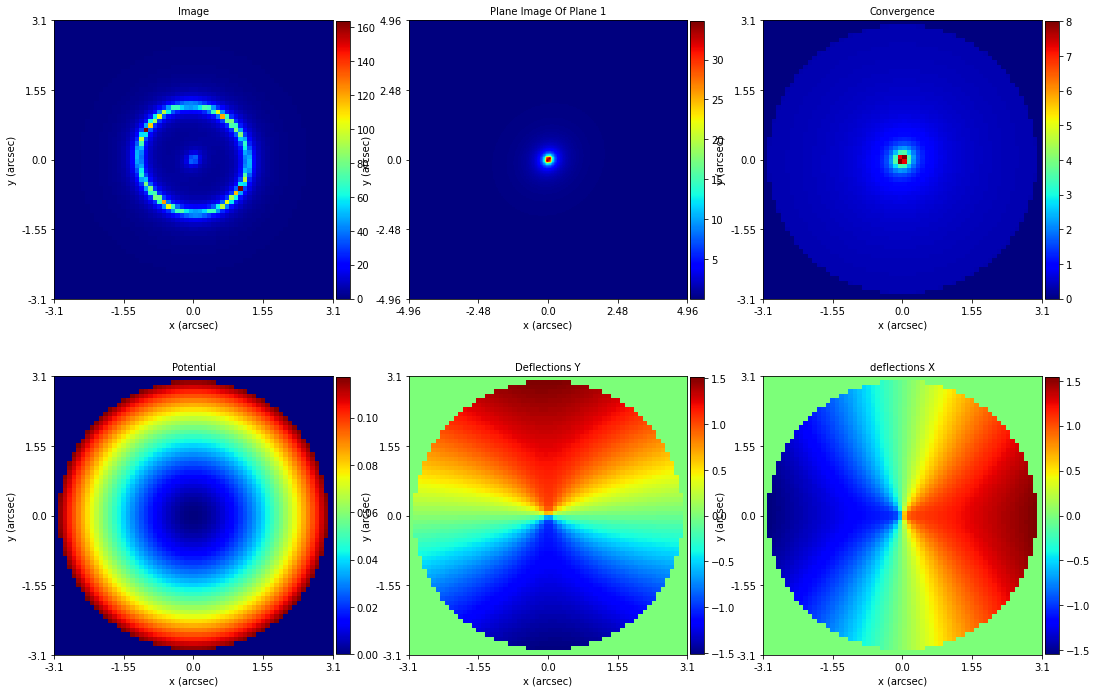

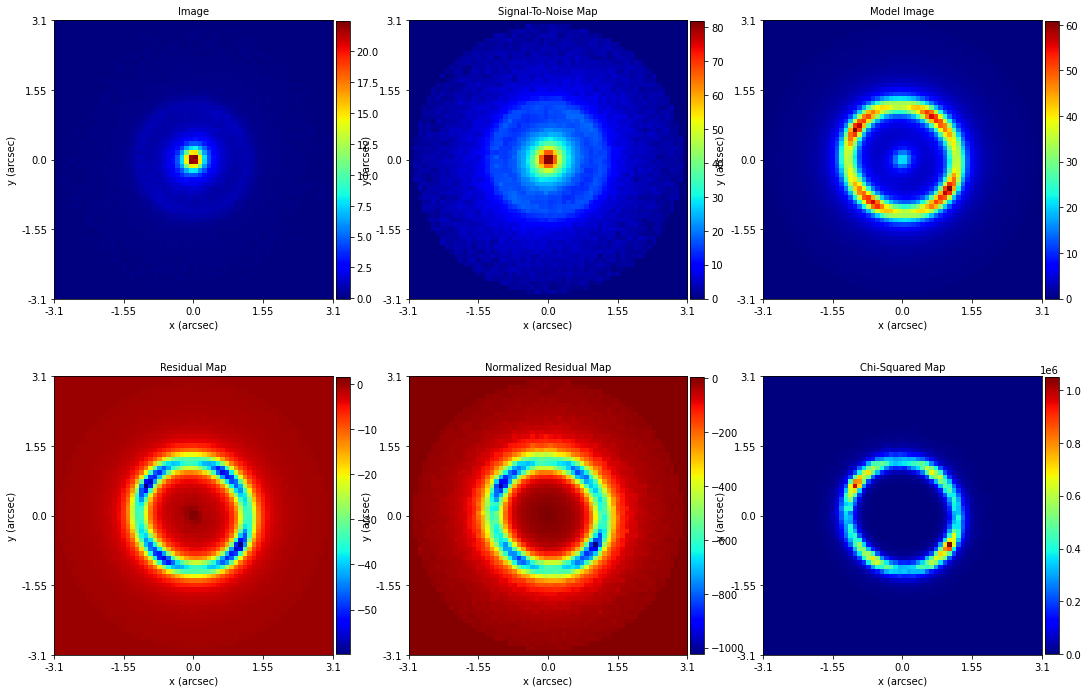

In [8]:
print(result.max_log_likelihood_instance)

tracer_plotter = aplt.TracerPlotter(
    tracer=result.max_log_likelihood_tracer, grid=result.grid
)
tracer_plotter.subplot_tracer()

fit_imaging_plotter = aplt.FitImagingPlotter(fit=result.max_log_likelihood_fit)
fit_imaging_plotter.subplot_fit_imaging()

Checkout `autolens_workspace/notebooks/imaging/modeling/results.py` for a full description of the result object.